In [22]:
from tqdm import tqdm
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import segmentation_models_pytorch as smp
from torchvision.utils import make_grid

import model
import metrics
import config
import utis

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from dataset import HistoricalImagesDataset
import config
import glob

# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb

In [23]:
# Paths
IMAGES_PATH = '../data/patches/images/1942'
MASK_PATH = '../data/patches/masks/1942'
BEST_MODEL = '../best_model'
# PREDICTIONS_PATH = 

image_paths = glob.glob(IMAGES_PATH +'/*.tif')[:40]
mask_paths = glob.glob(MASK_PATH +'/*.tif')[:40]

### Weights and Biases

In [17]:
!wandb login

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


### Dataloader

In [24]:
# Dataset Object 
print('Number of image patches:', len(image_paths),'\nNumber of mask patches:', len(mask_paths))
dataset = HistoricalImagesDataset(image_paths, mask_paths)
data = next(iter(dataset))
print('shape image', data[0].shape, 'shape mask', data[1].shape)       

# Train, Test, Split -- DEVEOLP A SPLITTING STRATEGY BASED ON THE SPATIAL INFORMATION !!!!!!!!!
print('Splitting data into TRAIN, VAL and TEST')
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) #-- pytorch alternative to the train_test_split command line from Scikit-Learn

train_size = int(0.5 * len(train_dataset))
val_size = len(train_dataset) - train_size
test_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
print("Training set size: ", len(train_dataset))
train_dataloader = DataLoader(dataset=train_dataset, batch_size = config.BATCH_SIZE)
print("Validation set size: ", len(val_dataset))
val_dataloader = DataLoader(dataset=val_dataset, batch_size = config.BATCH_SIZE)
print("Testing set size: ", len(test_dataset))
test_dataloader = DataLoader(dataset=test_dataset, batch_size = config.BATCH_SIZE)

Number of image patches: 40 
Number of mask patches: 40
shape image torch.Size([1, 256, 256]) shape mask torch.Size([1, 256, 256])
Splitting data into TRAIN, VAL and TEST
Training set size:  20
Validation set size:  10
Testing set size:  10


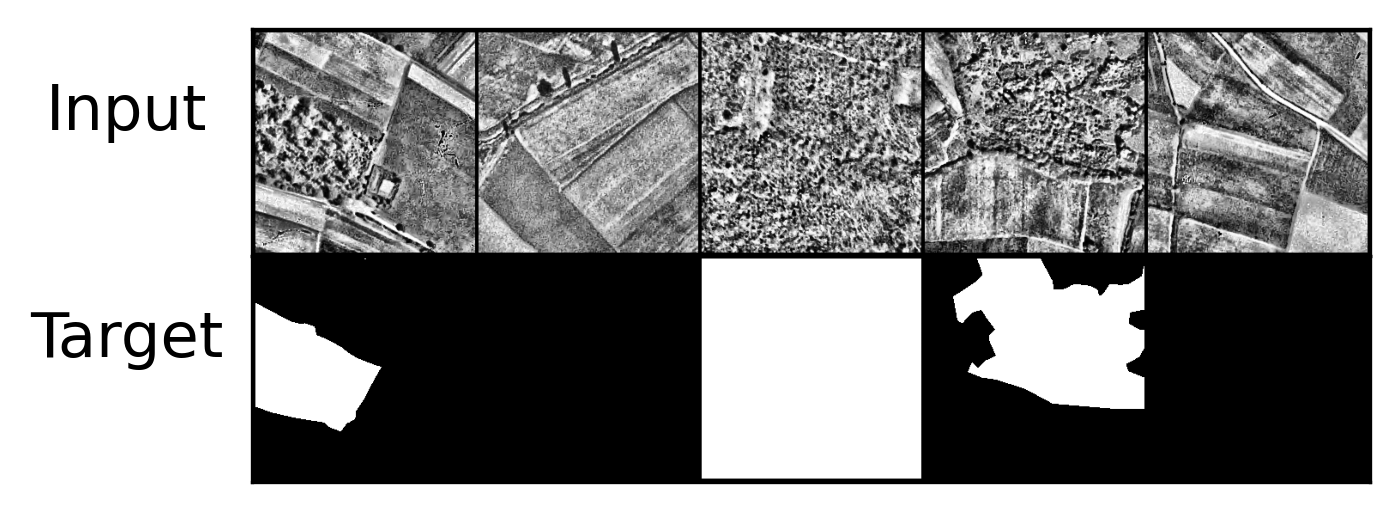

In [25]:
val_dataloader_iter = iter(val_dataloader)
grids = utis.create_segement_grids(val_dataloader_iter)
utis.plot_grids(grids)

### Check if CUDA is available

In [21]:
config.DEVICE

'cpu'

### Training

In [7]:
def train(model, dataloader, optim, lossFunc, epoch, scaler):
    # set the model in training mode
    model.train()

    # Save total train loss
    totalTrainLoss = 0
    
    # metrics
    accuracy = 0
    iou = 0
    f1score = 0
    
    # loop over the training set
    loop = tqdm(dataloader, leave=False)
    for x, y in loop:
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.float().to(config.DEVICE))
        
        # forward with autocast        
        with autocast():
            pred = model(x)
            loss = lossFunc(pred, y)
            
        optim.zero_grad()  # zero out any previously accumulated gradients    
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        
        totalTrainLoss += loss  # add the loss to the total training loss so far 

#         # forward
#         # with torch.cuda.amp.autocast(): # setting float16 to speed up the traiing
#         pred = model(x)
#         loss = lossFunc(pred, y)
        
#         optim.zero_grad()  # zero out any previously accumulated gradients
#         loss.backward() # obtain the gradients with respect to the loss
#         optim.step() # perform one step of gradient descendent
#         totalTrainLoss += loss  # add the loss to the total training loss so far 
        
        # metrics      
        all_metrics = metrics.metrics(pred, y)
        accuracy += all_metrics['acc']
        iou += all_metrics['iou']
        f1score += all_metrics['f1score']
        
        # update tqdm
        loop.set_description(f'Training Epoch [{epoch}/{config.NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), acc = all_metrics['acc'], iou=all_metrics['iou'])
        
    # calculate the average training loss PER EPOCH
    avgTrainLoss = totalTrainLoss / len(dataloader)
    avgAccLoss = accuracy / len(dataloader)
    avgIOU = iou / len(dataloader)
    avgF1score = f1score / len(dataloader)
    
    ## update training history
    training_history["avg_train_loss"].append(avgTrainLoss.cpu().detach().numpy()) # save the avg loss
    training_history["train_accuracy"].append(avgAccLoss) # save the acc 
    training_history["IoU"].append(avgIOU) # save the iou
    training_history["f1score"].append(avgF1score) # save the f1score
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Train Loss": avgTrainLoss,
    "Train Accuracy": avgAccLoss,
    "IoU_train":avgIOU})
    
    return training_history

In [8]:
def validation(model, dataloader, lossFunc, epoch):
    # Save total train loss
    totalValLoss = 0
    
    # metrics
    accuracy_val = 0
    iou_val = 0
    f1score_val = 0
    
    iter_ = 1
    # switch off autograd
    with torch.no_grad():
    # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        loop = tqdm(dataloader, leave=False)
        for (x_val, y_val) in loop:
            # send the input to the device
            (x_val, y_val) = (x_val.to(config.DEVICE), y_val.to(config.DEVICE))
            
            # make the predictions and calculate the validation loss
            pred_val = model(x_val)
            loss = lossFunc(pred_val, y_val)
            totalValLoss += loss
            
            # metrics      
            all_metrics = metrics.metrics(pred_val, y_val)
            accuracy_val += all_metrics['acc']
            iou_val += all_metrics['iou']
            f1score_val += all_metrics['f1score']
            
            # Plotting Val 
            # if iter_  % 2 == 0: # plot every time iter is a multiple of 2
            utis.plot_comparison(x_val, pred_val, y_val)
            iter_ += 1 
            
            # update tqdm
            loop.set_description(f'Validation Epoch [{epoch}/{config.NUM_EPOCHS}]')
            loop.set_postfix(loss_val=loss.item(), acc_val = all_metrics['acc'], iou_val=all_metrics['iou'])

                        
    # calculate the average VALIDATION loss PER EPOCH
    avgValLoss = totalValLoss / len(dataloader)
    avgAccLoss = accuracy_val / len(dataloader)
    avgIOU = iou_val / len(dataloader)
    avgF1score = f1score_val / len(dataloader)

    ## update VALIDATION history
    validation_history["avg_val_loss"].append(avgValLoss.cpu().detach().numpy()) # save the avg loss
    validation_history["val_accuracy"].append(avgAccLoss) # save the acc
    validation_history["IoU_val"].append(avgIOU) # save the iou
    validation_history["f1score_val"].append(avgF1score) # save the iou
    
    # WANDB
    wandb.log({
    # "Examples": example_images,
    "Val Accuracy": avgAccLoss,
    "Val Loss": avgValLoss,
    "IoU_val": avgIOU})
    
    return validation_history

In [9]:
# unet = model.unet_model.to(config.DEVICE)
# unet

### MAIN

wandb: Currently logged in as: vibferreira (use `wandb login --relogin` to force relogin)


/share/etud/e2008984/miniconda3/envs/jupyter_pratixa/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


Training the network for 10 epochs, with a batch size of 5


  0%|                                                                                                                                    | 0/4 [00:00<?, ?it/s]/share/etud/e2008984/miniconda3/envs/jupyter_pratixa/lib/python3.8/site-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

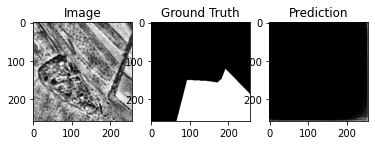

Validation Epoch [0/10]:  50%|█████████████████████                     | 1/2 [00:01<00:01,  1.20s/it, acc_val=0.9955672, iou_val=0.0013534751, loss_val=0.995]

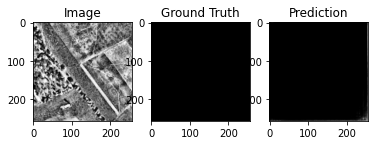

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

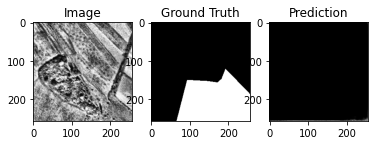

Validation Epoch [1/10]:  50%|█████████████████████                     | 1/2 [00:00<00:00,  1.11it/s, acc_val=0.9945167, iou_val=0.0021386982, loss_val=0.994]

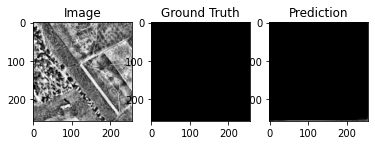

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

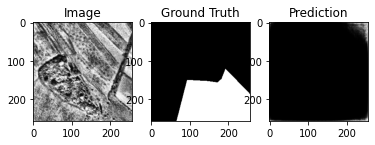

Validation Epoch [2/10]:  50%|████████████████████▌                    | 1/2 [00:00<00:00,  1.25it/s, acc_val=0.93665683, iou_val=0.0038203343, loss_val=0.993]

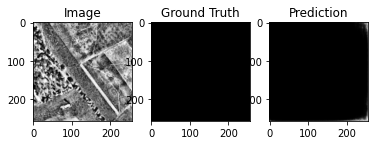

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

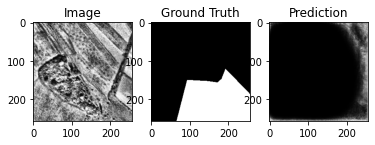

Validation Epoch [3/10]:  50%|█████████████████████                     | 1/2 [00:00<00:00,  1.07it/s, acc_val=0.90416443, iou_val=0.003634284, loss_val=0.994]

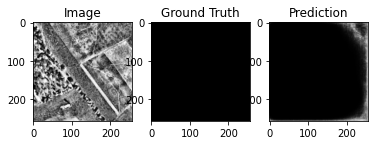

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

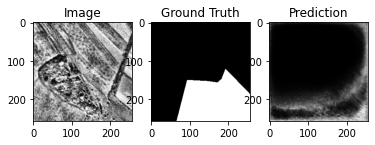

Validation Epoch [4/10]:  50%|████████████████████▌                    | 1/2 [00:00<00:00,  1.20it/s, acc_val=0.85344946, iou_val=0.0033599434, loss_val=0.995]

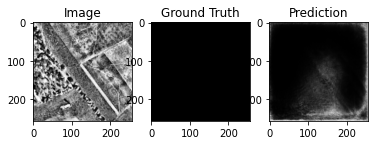

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

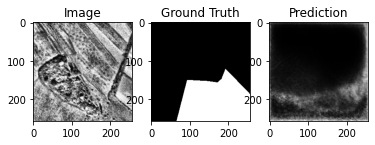

Validation Epoch [5/10]:  50%|█████████████████████                     | 1/2 [00:01<00:01,  1.02s/it, acc_val=0.86263025, iou_val=0.003411363, loss_val=0.995]

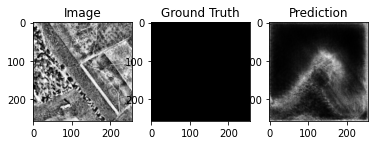

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

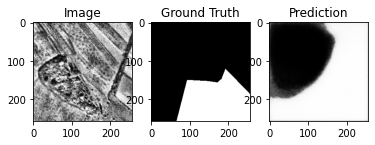

Validation Epoch [6/10]:  50%|████████████████████▌                    | 1/2 [00:01<00:01,  1.35s/it, acc_val=0.41575846, iou_val=0.0017838273, loss_val=0.997]

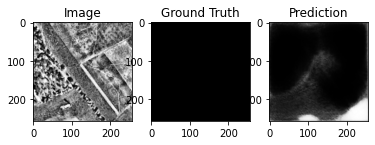

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

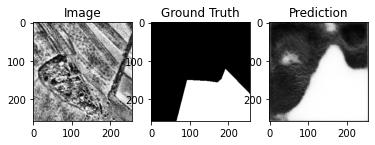

Validation Epoch [7/10]:  50%|██████████████████████                      | 1/2 [00:00<00:00,  1.17it/s, acc_val=0.491774, iou_val=0.002031373, loss_val=0.996]

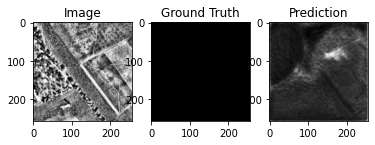

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

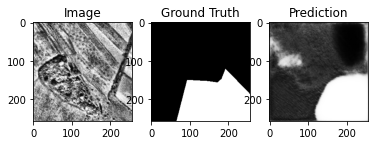

Validation Epoch [8/10]:  50%|████████████████████▌                    | 1/2 [00:01<00:01,  1.04s/it, acc_val=0.73911816, iou_val=0.0035824892, loss_val=0.995]

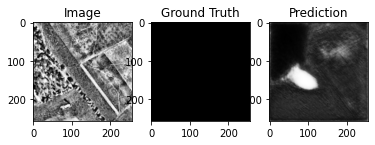

  0%|                                                                                                                                    | 0/2 [00:00<?, ?it/s]

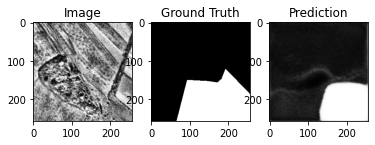

Validation Epoch [9/10]:  50%|█████████████████████                     | 1/2 [00:00<00:00,  1.32it/s, acc_val=0.7617166, iou_val=0.0038388374, loss_val=0.994]

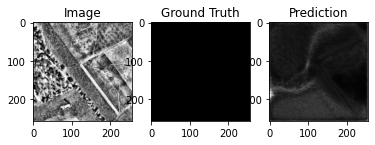

In [10]:
# WandB – Initialize a new run
wandb.init(entity="vibferreira", project="master_thesis")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release

# Initialize our model
unet = model.unet_model.to(config.DEVICE)

# initialize loss function and optimizer
lossFunc = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
opt = optim.Adam(unet.parameters(), lr=config.LR)

# initialize a dictionary to store TRAINING history (keep track on training)
training_history = {"avg_train_loss": [], "train_accuracy": [], "IoU":[],"f1score":[]}

# # initialize a dictionary to store VALIDATION history (keep track on VALIDATION)
validation_history = {"avg_val_loss": [], "val_accuracy": [], "IoU_val":[], "f1score_val":[]}

# Using log="all" log histograms of parameter values in addition to gradients
wandb.watch(unet, log="all")

# Autocasting 
scaler = GradScaler()

# initialize best accuracy
best_accuracy = 0.0
print(f'''Training the network for {config.NUM_EPOCHS} epochs, with a batch size of {config.BATCH_SIZE}''') # try with logger

# loop = tqdm(range(config.NUM_EPOCHS))
for e in range(config.NUM_EPOCHS):
    trained = train(unet, train_dataloader, opt, lossFunc, epoch=e, scaler=scaler)
    validated = validation(unet, val_dataloader, lossFunc, epoch=e)
    
    # Save best model
    if validated['val_accuracy'][-1] > best_accuracy : # maybe add a minimum number of epochs as conditions
        utis.save_best_model(unet, BEST_MODEL, validated, e)
        best_accuracy = validation_history['val_accuracy'][-1]

### Predictions

In [11]:
def save_predictions_as_imgs():
    pass

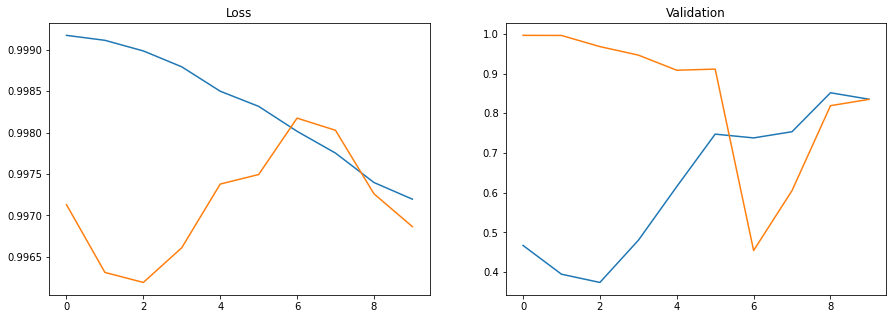

In [12]:
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].plot(training_history['avg_train_loss'], label= 'train')
ax[0].plot(validation_history['avg_val_loss'], label='val')
ax[0].set_title('Loss')
ax[1].plot(training_history['train_accuracy'], label= 'train')
ax[1].plot(validation_history['val_accuracy'], label='val')
ax[1].set_title('Validation')
plt.show()